In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
def detect_missing_data_type(df):
    """
    Detects missing data type (MCAR, MAR, MNAR) without using Logistic Regression.
    """
    print("\n========== Step 1: Visualizing Missing Data ==========\n")
    msno.matrix(df)
    msno.heatmap(df)

    print("\n========== Step 2: Performing Little’s MCAR Test ==========\n")
    try:
        from sklearn.impute import SimpleImputer
        df_encoded = df.copy()
        for col in df_encoded.select_dtypes(include=['object']).columns:
            df_encoded[col] = df_encoded[col].astype('category').cat.codes
        
        imputer = SimpleImputer(strategy="mean")
        df_imputed = imputer.fit_transform(df_encoded)
        
        s_complete = np.cov(df_imputed, rowvar=False)
        s_missing = np.cov(df_encoded.dropna(), rowvar=False)
        
        chi_square_stat = np.sum((s_complete - s_missing) ** 2 / s_complete)
        df_degrees_of_freedom = s_complete.shape[0] ** 2
        p_value = 1 - stats.chi2.cdf(chi_square_stat, df_degrees_of_freedom)

        print(f"Little’s MCAR Test p-value: {p_value:.4f}")
        if p_value > 0.05:
            print("MCAR: The missing data is likely Missing Completely at Random (MCAR).")
        else:
            print("The missing data is NOT completely random, may be MAR or MNAR.")
    except:
        print("MCAR Test failed. Ensure all variables are numeric or categorical.")

    print("\n========== Step 3: Chi-Square Test for MAR Detection ==========\n")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col + "_missing"] = df[col].isnull().astype(int)
            for other_col in df.columns:
                if other_col != col and df[other_col].dtype == 'object':
                    contingency_table = pd.crosstab(df[col + "_missing"], df[other_col])
                    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
                    print(f"Chi-square test for {col} vs {other_col}: p-value = {p:.4f}")
                    if p < 0.05:
                        print(f"--> Missingness in '{col}' is likely MAR (related to '{other_col}').")

    print("\n========== Step 4: Random Forest Classifier for MAR Detection ==========\n")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col + "_missing"] = df[col].isnull().astype(int)
            X = df.drop(columns=[col, col + "_missing"]).select_dtypes(include=[np.number])
            y = df[col + "_missing"]

            if X.shape[1] > 0:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
                
                # 处理 NaN
                X_train = X_train.fillna(X_train.mean())
                X_test = X_test.fillna(X_test.mean())

                if len(X_train) > 0:
                    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                    rf_model.fit(X_train, y_train)
                    accuracy = rf_model.score(X_test, y_test)
                    print(f"Random Forest Accuracy for {col}: {accuracy:.4f}")
                    if accuracy > 0.6:
                        print(f"--> Missingness in '{col}' is likely MAR.")

    print("\n========== Step 5: Checking MNAR Possibility ==========\n")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            print(f"Checking MNAR for {col}...")
            df[col + "_missing"] = df[col].isnull().astype(int)
            missing_group = df[df[col + "_missing"] == 1][col]
            non_missing_group = df[df[col + "_missing"] == 0][col]
            if missing_group.notnull().sum() > 0 and non_missing_group.notnull().sum() > 0:
                t_stat, p_val = stats.ttest_ind(missing_group, non_missing_group, nan_policy='omit')
                print(f"T-test p-value for {col}: {p_val:.4f}")
                if p_val < 0.05:
                    print(f"--> The missingness in '{col}' is likely MNAR.")
                else:
                    print(f"--> The missingness in '{col}' does not show strong MNAR characteristics.")

    print("\n========== Final Conclusion ==========\n")
    print("Use the results above to determine if your missing data is MCAR, MAR, or MNAR.")


========== Step 1: Visualizing Missing Data ==========


========== Step 2: Performing Little’s MCAR Test ==========

Little’s MCAR Test p-value: 0.0000
The missing data is NOT completely random, may be MAR or MNAR.

========== Step 3: Chi-Square Test for MAR Detection ==========


========== Step 4: Random Forest Classifier for MAR Detection ==========

Random Forest Accuracy for Heart Rate_mean_120: 0.9811
--> Missingness in 'Heart Rate_mean_120' is likely MAR.
Random Forest Accuracy for Resp Rate_mean_120: 0.9781
--> Missingness in 'Resp Rate_mean_120' is likely MAR.
Random Forest Accuracy for SaO2_mean_120: 0.8507
--> Missingness in 'SaO2_mean_120' is likely MAR.
Random Forest Accuracy for Temp/Iso/Warmer_mean_120: 0.7676
--> Missingness in 'Temp/Iso/Warmer_mean_120' is likely MAR.
Random Forest Accuracy for Temp Skin [C]_mean_120: 0.9210
--> Missingness in 'Temp Skin [C]_mean_120' is likely MAR.
Random Forest Accuracy for BP Cuff [Systolic]_mean_120: 0.9995
--> Missingness in 'BP

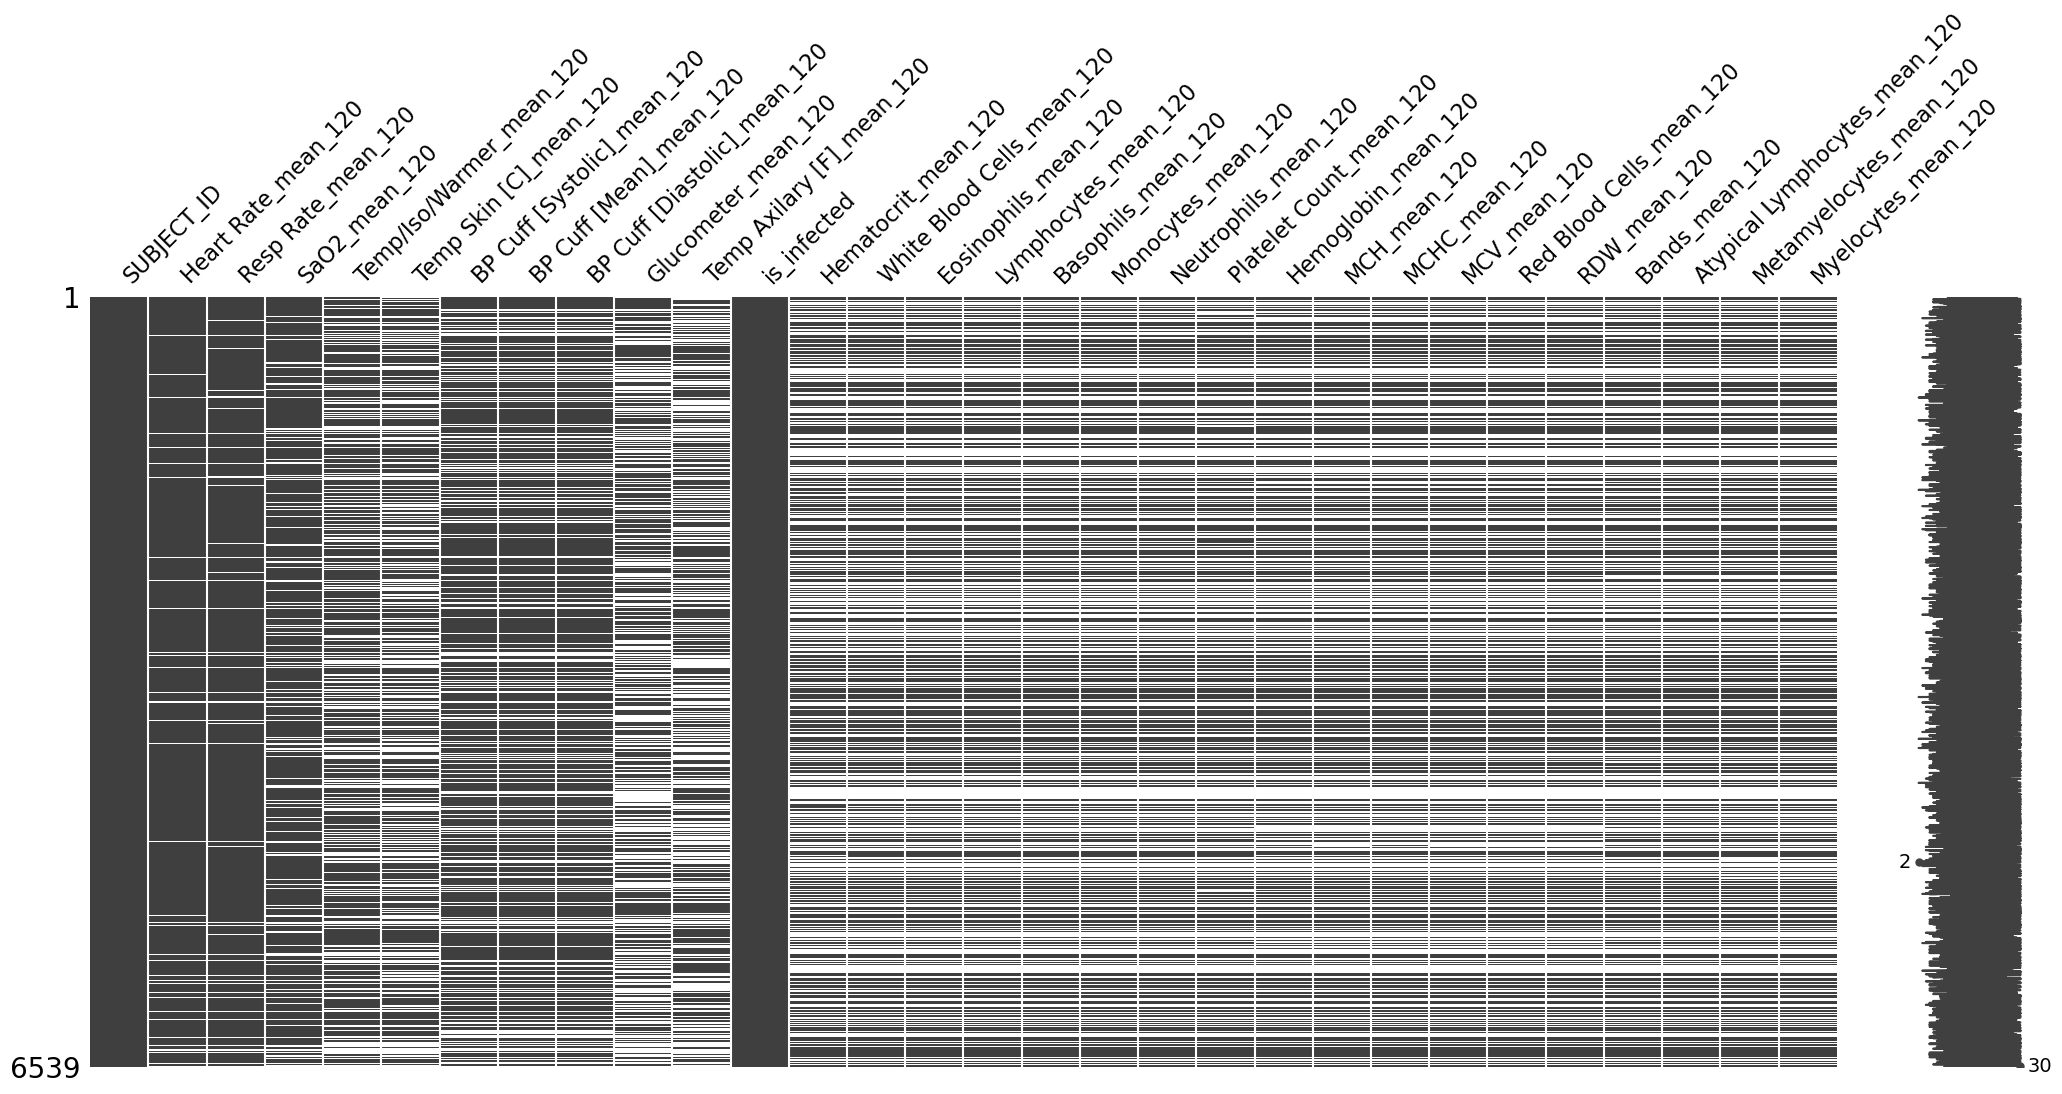

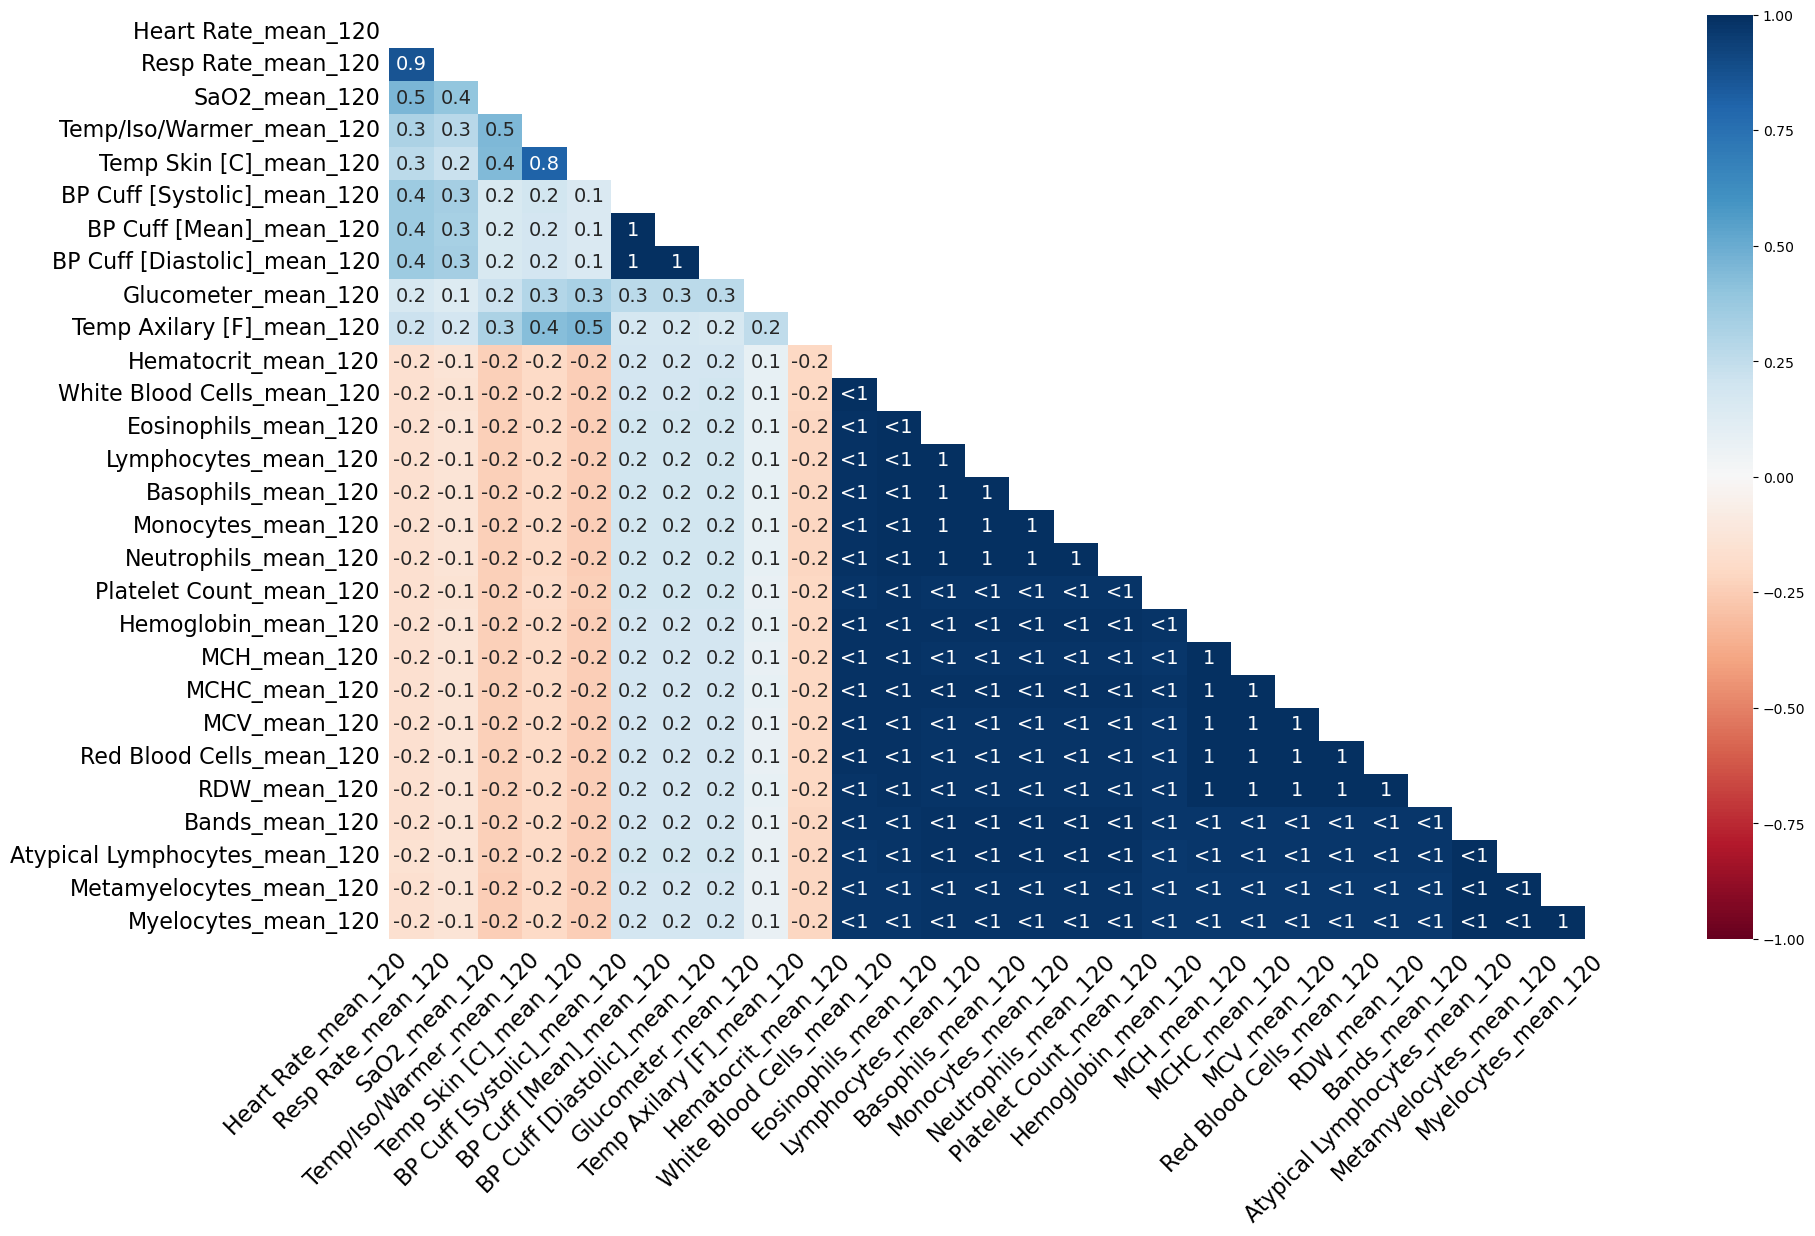

In [4]:
df = pd.read_csv("../data/final/nicu_120.csv")

# 删除包含 "min_120" 或 "max_120" 的列
df = df.drop(columns=[col for col in df.columns if "min_120" in col or "max_120" in col])
# Run the detection function
detect_missing_data_type(df)

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

def detect_missing_data_type(df):
    """
    Detects missing data mechanisms (MCAR, MAR, MNAR) and returns an aggregated summary.
    Note: Real data can exhibit more than one mechanism in different columns.
    """

    # Dictionary to store results
    final_results = {
        "MCAR_test": None,        # Will hold p-value for MCAR test
        "Likely_MCAR": False,     # Whether the dataset is globally MCAR
        "Columns_MAR": set(),     # Columns likely MAR via chi-square or RF
        "Columns_MNAR": set(),    # Columns likely MNAR via t-test
    }

    print("\n========== Step 1: Visualizing Missing Data ==========\n")
    msno.matrix(df)
    msno.heatmap(df)

    #----------------- STEP 2: Little’s MCAR Test -----------------
    print("\n========== Step 2: Performing Little’s MCAR Test ==========\n")
    try:
        df_encoded = df.copy()
        # Convert object columns to categorical codes
        for col in df_encoded.select_dtypes(include=['object']).columns:
            df_encoded[col] = df_encoded[col].astype('category').cat.codes
        
        # Impute purely to get a complete matrix for covariance
        imputer = SimpleImputer(strategy="mean")
        df_imputed = imputer.fit_transform(df_encoded)
        
        # Covariance of entire imputed dataset
        s_complete = np.cov(df_imputed, rowvar=False)
        # Covariance of only fully observed rows
        df_dropped_na = df_encoded.dropna()
        if df_dropped_na.shape[0] < 2:
            # Edge case: if dropping NaN leaves too few rows for covariance
            print("Not enough fully observed rows to perform MCAR test.")
        else:
            s_missing = np.cov(df_dropped_na, rowvar=False)

            # Chi-square-like statistic
            chi_square_stat = np.sum((s_complete - s_missing) ** 2 / s_complete)
            df_degrees_of_freedom = s_complete.shape[0] ** 2
            p_value = 1 - stats.chi2.cdf(chi_square_stat, df_degrees_of_freedom)

            final_results["MCAR_test"] = p_value
            print(f"Little’s MCAR Test p-value: {p_value:.4f}")
            if p_value > 0.05:
                final_results["Likely_MCAR"] = True
                print("MCAR: The missing data is likely Missing Completely at Random (MCAR).")
            else:
                print("The missing data is NOT completely random, may be MAR or MNAR.")
    except Exception as e:
        print(f"MCAR Test failed: {e}")
        print("Ensure all variables are numeric or categorical, or that enough rows remain for covariance.")

    #----------------- STEP 3: Chi-Square Test for MAR Detection -----------------
    print("\n========== Step 3: Chi-Square Test for MAR Detection ==========\n")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            missing_indicator = col + "_missing"
            df[missing_indicator] = df[col].isnull().astype(int)
            # Check association with other categorical columns
            for other_col in df.columns:
                if other_col != col and df[other_col].dtype == 'object':
                    contingency_table = pd.crosstab(df[missing_indicator], df[other_col])
                    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
                        chi2, p, _, _ = stats.chi2_contingency(contingency_table)
                        if p < 0.05:
                            final_results["Columns_MAR"].add(col)
                            print(f"Chi-square test for {col} vs {other_col}: p-value = {p:.4f}")
                            print(f"--> Missingness in '{col}' is likely MAR (related to '{other_col}').")

    #----------------- STEP 4: Random Forest Classifier for MAR Detection -----------------
    print("\n========== Step 4: Random Forest Classifier for MAR Detection ==========\n")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            missing_indicator = col + "_missing"
            # If we didn't create the indicator above, create it now
            if missing_indicator not in df.columns:
                df[missing_indicator] = df[col].isnull().astype(int)

            X = df.drop(columns=[col, missing_indicator]).select_dtypes(include=[np.number])
            y = df[missing_indicator]

            # Only proceed if we have at least 1 numeric feature
            if X.shape[1] > 0 and X.shape[0] > 1:
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.3, random_state=42
                )

                # Fill numeric NaN in features with mean
                X_train = X_train.fillna(X_train.mean())
                X_test = X_test.fillna(X_test.mean())

                if len(X_train) > 0 and len(np.unique(y_train)) > 1:
                    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                    rf_model.fit(X_train, y_train)
                    accuracy = rf_model.score(X_test, y_test)
                    print(f"Random Forest Accuracy for {col}: {accuracy:.4f}")
                    if accuracy > 0.60:
                        final_results["Columns_MAR"].add(col)
                        print(f"--> Missingness in '{col}' is likely MAR (based on RF classification).")

    #----------------- STEP 5: Checking MNAR Possibility -----------------
    print("\n========== Step 5: Checking MNAR Possibility ==========\n")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            print(f"Checking MNAR for '{col}'...")
            missing_indicator = col + "_missing"
            if missing_indicator not in df.columns:
                df[missing_indicator] = df[col].isnull().astype(int)

            missing_group = df[df[missing_indicator] == 1][col]
            non_missing_group = df[df[missing_indicator] == 0][col]

            # We need some numeric data to do t-test
            if pd.api.types.is_numeric_dtype(df[col]) and missing_group.notnull().sum() > 0 and non_missing_group.notnull().sum() > 0:
                t_stat, p_val = stats.ttest_ind(missing_group, non_missing_group, nan_policy='omit')
                print(f"T-test p-value for {col}: {p_val:.4f}")
                if p_val < 0.05:
                    final_results["Columns_MNAR"].add(col)
                    print(f"--> The missingness in '{col}' is likely MNAR.")
                else:
                    print(f"--> The missingness in '{col}' does not show strong MNAR characteristics.")
            else:
                print(f"Skipping MNAR t-test for '{col}' due to non-numeric or insufficient data.")

    print("\n========== Final Conclusion ==========\n")
    # Summarize MCAR results
    if final_results["MCAR_test"] is not None:
        if final_results["Likely_MCAR"]:
            print("Global MCAR test suggests the dataset may be MCAR overall.")
        else:
            print("Global MCAR test suggests data are not MCAR overall.")
    else:
        print("No conclusive MCAR test result.")

    # Summarize MAR columns
    if len(final_results["Columns_MAR"]) > 0:
        print(f"Columns likely MAR: {list(final_results['Columns_MAR'])}")
    else:
        print("No columns show strong evidence of MAR under chi-square or RF criteria.")

    # Summarize MNAR columns
    if len(final_results["Columns_MNAR"]) > 0:
        print(f"Columns likely MNAR: {list(final_results['Columns_MNAR'])}")
    else:
        print("No columns show strong evidence of MNAR from the t-test criteria.")

    # Attempt an overall classification
    # If MCAR test suggests not MCAR, and we found columns in MAR, possibly it's MAR.
    # If we found columns MNAR, it might be partially MNAR.
    # Real data can be mixed, but let's attempt a short statement:
    if final_results["Likely_MCAR"]:
        print("Overall, the dataset appears to be mostly MCAR.")
    else:
        if len(final_results["Columns_MAR"]) > 0 and len(final_results["Columns_MNAR"]) == 0:
            print("Overall, the dataset appears mostly MAR.")
        elif len(final_results["Columns_MNAR"]) > 0 and len(final_results["Columns_MAR"]) == 0:
            print("Overall, the dataset shows indications of MNAR for some columns.")
        elif len(final_results["Columns_MNAR"]) > 0 and len(final_results["Columns_MAR"]) > 0:
            print("There is evidence that some columns may be MAR and others MNAR. The data are mixed.")

    print("\nUse the results above to refine your missing data handling strategy.")
    return final_results



========== Step 1: Visualizing Missing Data ==========


========== Step 2: Performing Little’s MCAR Test ==========

Little’s MCAR Test p-value: 0.0000
The missing data is NOT completely random, may be MAR or MNAR.

========== Step 3: Chi-Square Test for MAR Detection ==========


========== Step 4: Random Forest Classifier for MAR Detection ==========

Random Forest Accuracy for Heart Rate_mean_120: 0.9811
--> Missingness in 'Heart Rate_mean_120' is likely MAR (based on RF classification).
Random Forest Accuracy for Resp Rate_mean_120: 0.9781
--> Missingness in 'Resp Rate_mean_120' is likely MAR (based on RF classification).
Random Forest Accuracy for SaO2_mean_120: 0.8507
--> Missingness in 'SaO2_mean_120' is likely MAR (based on RF classification).
Random Forest Accuracy for Temp/Iso/Warmer_mean_120: 0.7676
--> Missingness in 'Temp/Iso/Warmer_mean_120' is likely MAR (based on RF classification).
Random Forest Accuracy for Temp Skin [C]_mean_120: 0.9210
--> Missingness in 'Temp Ski

{'MCAR_test': 0.0,
 'Likely_MCAR': False,
 'Columns_MAR': {'Atypical Lymphocytes_mean_120',
  'BP Cuff [Diastolic]_mean_120',
  'BP Cuff [Mean]_mean_120',
  'BP Cuff [Systolic]_mean_120',
  'Bands_mean_120',
  'Basophils_mean_120',
  'Eosinophils_mean_120',
  'Glucometer_mean_120',
  'Heart Rate_mean_120',
  'Hematocrit_mean_120',
  'Hemoglobin_mean_120',
  'Lymphocytes_mean_120',
  'MCHC_mean_120',
  'MCH_mean_120',
  'MCV_mean_120',
  'Metamyelocytes_mean_120',
  'Monocytes_mean_120',
  'Myelocytes_mean_120',
  'Neutrophils_mean_120',
  'Platelet Count_mean_120',
  'RDW_mean_120',
  'Red Blood Cells_mean_120',
  'Resp Rate_mean_120',
  'SaO2_mean_120',
  'Temp Axilary [F]_mean_120',
  'Temp Skin [C]_mean_120',
  'Temp/Iso/Warmer_mean_120',
  'White Blood Cells_mean_120'},
 'Columns_MNAR': set()}

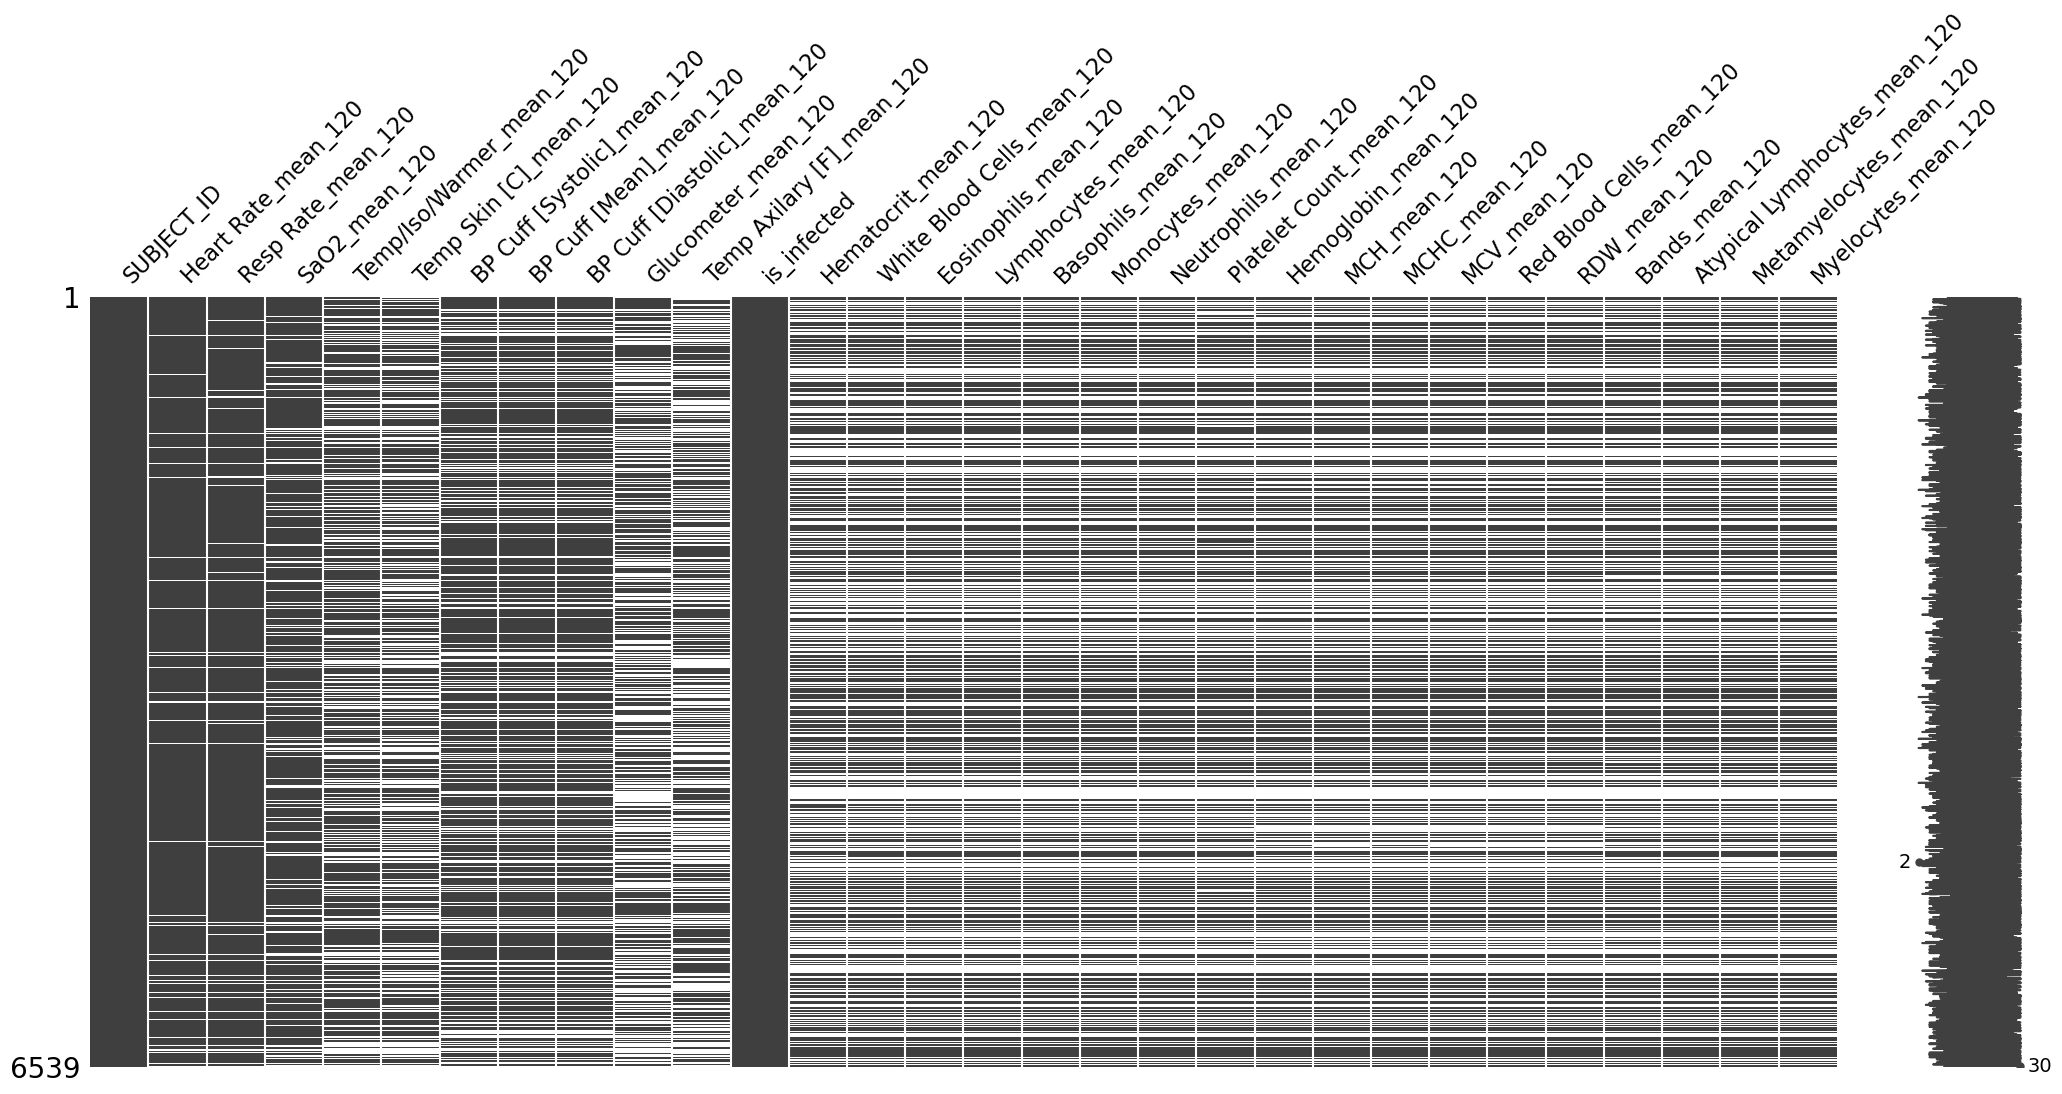

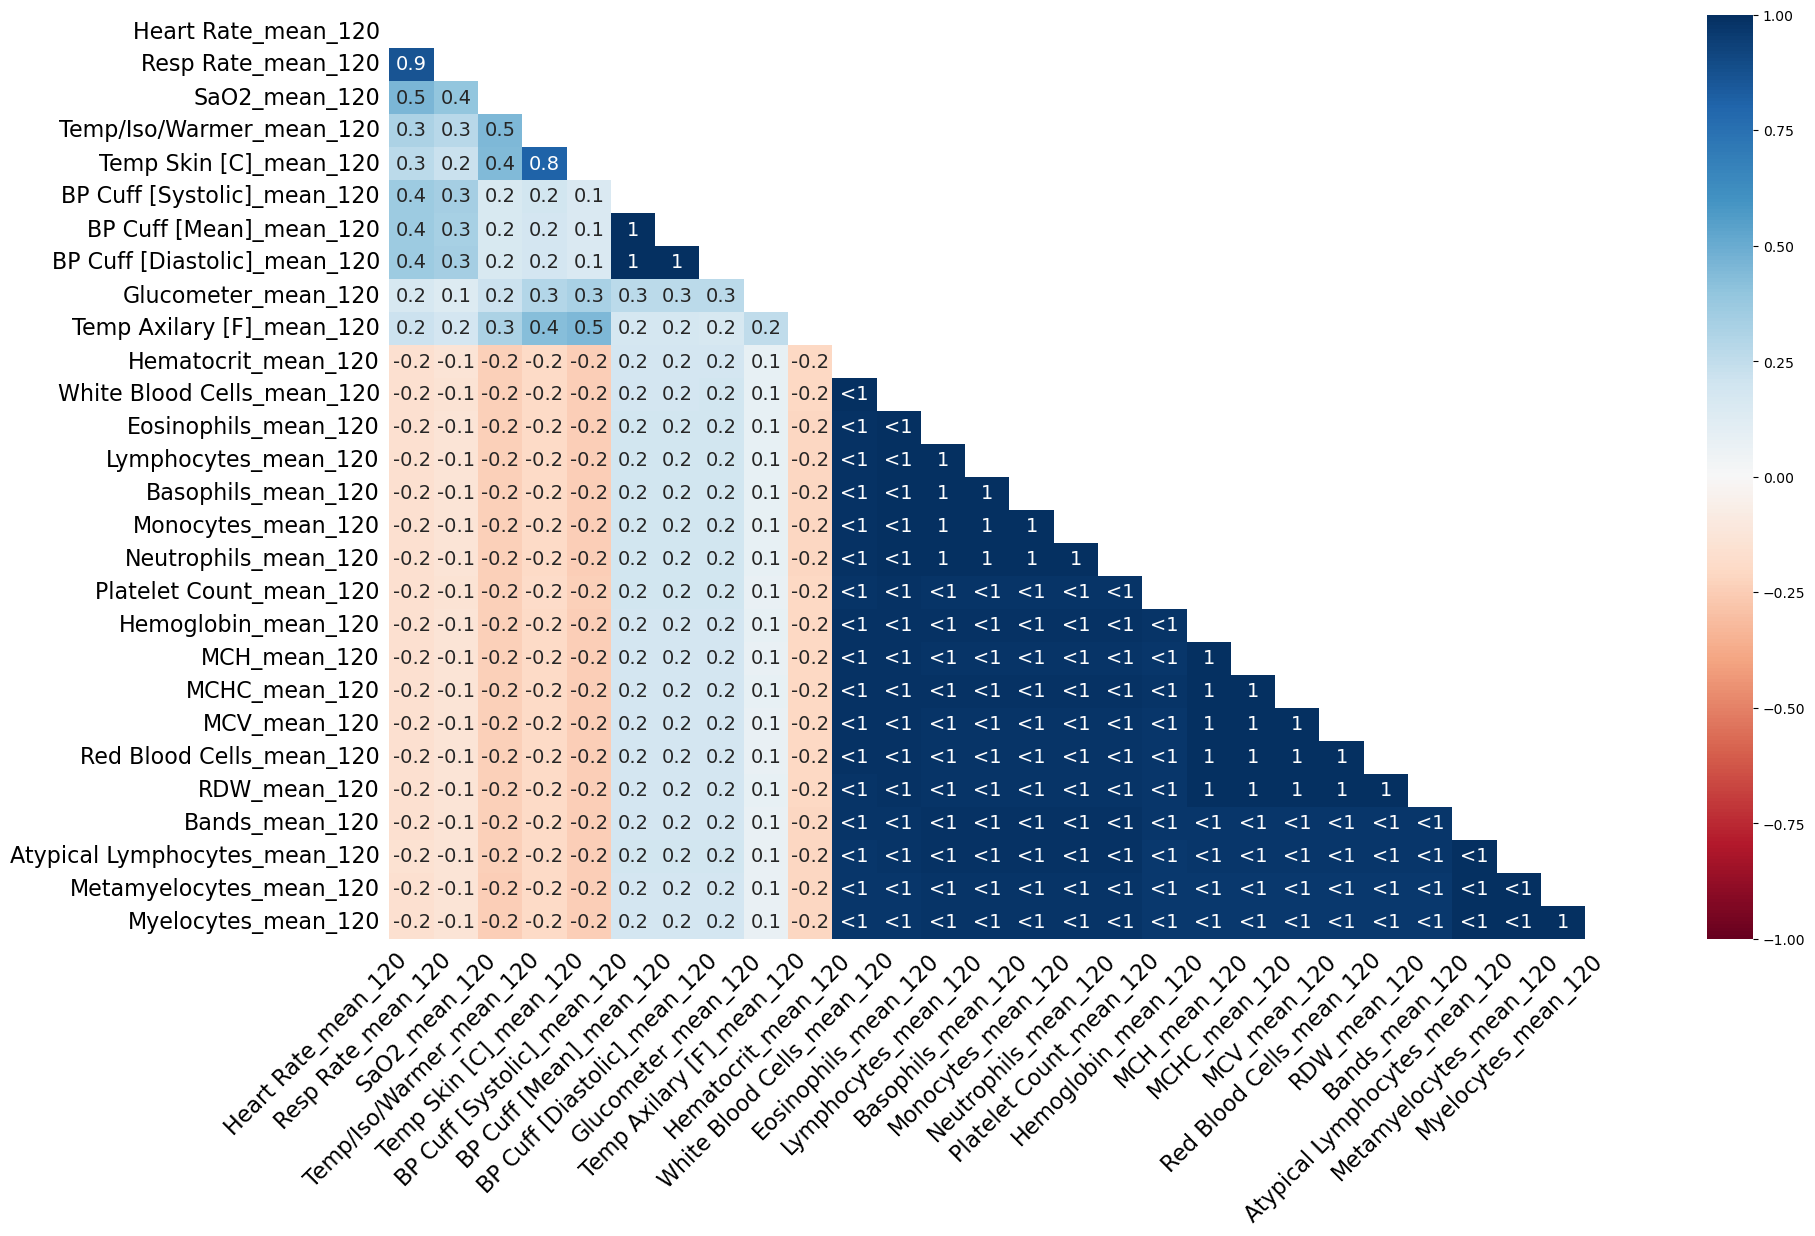

In [2]:
df = pd.read_csv("../data/final/nicu_120.csv")

# 删除包含 "min_120" 或 "max_120" 的列
df = df.drop(columns=[col for col in df.columns if "min_120" in col or "max_120" in col])
# Run the detection function
detect_missing_data_type(df)